# Indexação e Processamento de Consulta (Lab 4)  - Recuperação da Informação
**Aluno: Pedro Guedes Braga**


In [27]:
#coding: utf-8

import pandas as pd
import nltk
import operator
import math
import matplotlib.pyplot as pyplot
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import *
nltk.download('stopwords')
nltk.download('punkt') 
import csv

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**1 - Escolha uma estratégia de tokenização para a coleção que você está usando e justifique sua estratégia. É importante que você inclua decisões adicionais em relação ao que foi feito no Laboratório anterior (por exemplo, tratamento de maiúsculas/minúsculas e strings numéricas) (5 pts).**




- Tratamos um *token* como sendo qualquer sequencia de caracteres alfanuméricos que termine com espaço ou outro caractere especial. 

**Estratégias de tokenização usadas:**
-  **Tratamento de maiúsculas/minúsculas (*Normalization/downcasing*):**  Para a amostra de notícias, foi identificado um grande número de palavras que apareciam de formas diferentes, por vários fatores. Por exemplo: A palavra "ser", ao aparecer iniciando um' parágrafo ou após um ponto, tinha a letra "S" maiúscula ("Ser"). Já quando aparecia em outro "local" no texto, vinha com o "s" minúsculo ("ser"). Se isso não fosse tratado, o nosso vocabulário seria gerado com redundancia (haveria duas palavras tratadas como diferentes no vocabulário: "Ser" e "ser"). Sendo assim, foi aplicado uma normalização nos tokens identificados, deixando todos em *lowercase.*
-  **Removendo apóstrofos:** Também foi feito o uso de outra regra usada nas coleções do TREC muito efetiva, que consiste em remover apóstrofos de um token. Ex.: O'Connor -> oconnor.
- ** Ignorando pontos em abreviações:** Também foi utilizado outra regra usada nas coleções do TREC, que consiste em remover pontos em abreviações. Ex.: I.B.M. -> ibm.

In [48]:
url_csv = "https://raw.githubusercontent.com/PedroGuedesBraga/ri_lab_01/master/output/results.csv"
df = pd.read_csv(url_csv)
df.dropna(inplace=True)  ##Retira campos NA (ex.: NaN, etc)
lista_de_noticias = df.text.unique() #Retorna uma lista onde cada elemento é o texto de uma noticia.
 # http://www.nltk.org/howto/portuguese_en.html - Tutorial StopWords
 # https://pythonspot.com/tokenizing-words-and-sentences-with-nltk/
palavras_a_ignorar = nltk.corpus.stopwords.words('portuguese')
palavras_a_ignorar.append('o')
palavras_a_ignorar.append('a')
palavras_a_ignorar.append('é')
palavras_a_ignorar.append('r')
  
special_chars = [',', '.', '-', '“', "”", ")", "(", ":", "%", "?", "$", "–", ""]

##Funcao para construir o índice:
def build_index(documents):
  index = {}
  n = 0
  for document in documents:
    n = n + 1
    tokens = word_tokenize(document)
    for token in tokens:
      if((apply_tokenize_strategy(token.lower()) not in palavras_a_ignorar) and (apply_tokenize_strategy(token.lower()) not in special_chars)):  ## Todos os tokens passam a serem tratados em LOWERCASE
        if(apply_tokenize_strategy(token.lower()) in index):
          index[apply_tokenize_strategy(token.lower())].append((n, tokens.count(token)))
        else:
          index[apply_tokenize_strategy(token.lower())] = [(n, tokens.count(token))]
  refactored_index = aux_refactor_index(index)
  return refactored_index


#funcao auxiliar responsavel por refatorar as listas invertidas do indice para retorna-la no formato pedido. - Remove duplicatas de documentos
def aux_refactor_index(index):
  for word in index:
    for tupla in index[word]:
      index[word] = set(index[word])
  return index
    
  
indice = build_index(lista_de_noticias)

#Formata os dados para serem escritos em um arquivo CSV
def data_to_write_in_csv(index):
  data_to_write = []
  for word in index :
    data_to_write.append(word + "," + (str(index[word])).replace(",",""))
  data_to_write_string = "\n".join(data_to_write)
  return data_to_write_string


with open('index_result.csv', 'w') as writeFile:
  writeFile.write("Word,Inverted List\n")
  writeFile.write(data_to_write_in_csv(indice))
  

##Conta total de palavras
def conta_total_palavras(lista_noticias):
  total_words = 0
  for noticia in lista_noticias:
    tokens = word_tokenize(noticia)
    for token in tokens:
      if((token not in palavras_a_ignorar) and (token not in special_chars)):
        total_words += 1
  return total_words    


##Metodo auxiliar que remove apostrofos dos tokens, retornando um token em seu formato sem apostrofo
def remove_apostrophes(token):
  return token.replace("’", "").replace("'","")
  
##Metodo auxiliar que remove pontos em uma abreviacao
def remove_periods(token):
  return token.replace(".", "")

##Recebe um token(ja em lowercase) e aplica mais estratégias de tokenizacao, descritas pelas duas funcoes auxiliares acima.
def apply_tokenize_strategy(token):
  return remove_periods((remove_apostrophes(token)))


#Retorna um vocabulario, organizado da seguinte forma (em formato de dicionario): palavra(key): numero_de_ocorrencias_da_palavra(value)
def freq_palavras(lista_noticias):
  vocab = {}
  for noticia in lista_noticias:
    tokens = word_tokenize(noticia)
    for token in tokens:
      if((apply_tokenize_strategy(token.lower()) not in palavras_a_ignorar) and (apply_tokenize_strategy(token.lower()) not in special_chars)):  ## Todos os tokens passam a serem tratados em LOWERCASE
        if(apply_tokenize_strategy(token.lower()) in vocab):
          vocab[apply_tokenize_strategy(token.lower())] = vocab[apply_tokenize_strategy(token.lower())] + 1
        else:
          vocab[apply_tokenize_strategy(token.lower())] = 1 
  return vocab

#Recebe um o numero de vezes e o vocabulario
def words_more_than(times, vocab):
  count = 0
  for word in vocab:
    if(vocab[word] > times):
      count = count + 1
  return count

#Retorna numero de palavras que ocorreram apenas uma vez
def words_ocurring_once(vocab):
  count = 0
  for word in vocab:
    if(vocab[word] == 1):
      count = count + 1
  return count


vocabulario = freq_palavras(lista_de_noticias)
pd.DataFrame({'info': ['Documentos totais',
                       'Total de ocorrencias de palavras',
                      'Tamanho do Vocabulario',
                      'Palavras ocorrendo > 1000 vezes',
                       'Palavras ocorrendo uma única vez'
                      ],
              'valor': [len(df), 
                        conta_total_palavras(lista_de_noticias),
                        len(vocabulario),
                        words_more_than(1000, vocabulario),
                        words_ocurring_once(vocabulario)
                       ]
             })

,info,valor
0,Documentos totais,139
1,Total de ocorrencias de palavras,41879
2,Tamanho do Vocabulario,11284
3,Palavras ocorrendo > 1000 vezes,0
4,Palavras ocorrendo uma única vez,6289


**2 - Refaça a questão 2 do Laboratório anterior usando os tokens produzidos (5 pts). **


In [0]:
sorted_d = sorted(vocabulario.items(), key=operator.itemgetter(1), reverse = True)
total_palavras = conta_total_palavras(lista_de_noticias)
freq_relativa = [(v/total_palavras) for (k,v) in sorted_d[:50]]


#Calcula o valor da constante 'c' == Pr*r
def get_constants_values(freqs_relativas):
  constants_values = []
  for i in range(len(freqs_relativas)):
    c_value = freqs_relativas[i] * (i+1)
    constants_values.append(c_value)
  return constants_values


pd.DataFrame({
    'word': [k for (k,v) in sorted_d[:50]],
    'freq': [v for (k,v) in sorted_d[:50]],
    'Pr(%)': [round((v/total_palavras)*100, 2) for (k,v) in sorted_d[:50]],
    'Pr.r': get_constants_values(freq_relativa)
    
})

,word,freq,Pr(%),Pr.r
0,bolsonaro,186,0.44,0.004441
1,brasil,185,0.44,0.008835
2,ser,180,0.43,0.012894
3,anos,178,0.43,0.017001
4,governo,174,0.42,0.020774
5,sobre,129,0.31,0.018482
6,presidente,127,0.30,0.021228
7,país,123,0.29,0.023496
8,lula,114,0.27,0.024499
9,política,110,0.26,0.026266


**3 - Aplique Stemming nos tokens produzidos e encontre 10 exemplos de falsos positivos e 10 exemplos de falsos negativos. Que impacto você acha que falsos positivos e negativos, como esses, teriam no processamento de consultas? Dê exemplos. (5 pts).**

- **FALSOS POSITIVOS: **

"passeando" e "passado"

"animal" e "animou"

"fala" e "falimos"

"paris" e "parado"

"postos" e "postei"

"frança" e "franco"

"bandeira" e "bandeirante"

"prova" e "provem"

"sei" e "seio"

"apartamento" e	"aparte"

-----

**FALSOS NEGATIVOS**

"presidente" e "presidencia"

"dado" e "daria"

"deu" e "dado"

"daria" e "deu"

"paredes" e "paredão"

"influem" e "influenciar"

"irmã" e "irmãs"

"liderou" e "lidera"

"filmagens" e "filmes"

"duvida" e "duvidoso"

---

- **O impacto que esses falsos positivos e falsos negativos teriam nas consultas: **
Os falsos positivos/negativos podem ter algum impacto significante em algumas consultas, mas não de forma a comprometer todo o motor de busca. Por exemplo, sabendo que o algoritmo de *Stemming* utilizado **não foi capaz** de relacionar as palavras **"presidente"** e **"presidencia"**, suponhamos a hipótese que exista uma notícia que inicie da forma: "Presidencia decreta ..."". Se o usuário fizer uma consulta do formato "decreto presidente" (buscando esta notícia), o motor de busca terá uma dificuldade maior em trazer a notícia desejada se constrastarmos com o cenário em que as duas palavras estão relacionadas.




In [0]:
stemmer = SnowballStemmer("portuguese") # Algortimo PorterStemmer disponibilizado pela lib nltk
tokens = list(freq_palavras(lista_de_noticias).keys()) # Os tokens produzidos, no caso, estamos usando o vocabulario e pegando as chaves (palavras).
stemmed_tokens = [stemmer.stem(token) for token in tokens] # Aplica o algoritmo PorterStemmer aos tokens
dictionary = {}
for i in range(len(stemmed_tokens)):
  if(stemmed_tokens[i] in dictionary.keys()):
    dictionary[stemmed_tokens[i]].append(tokens[i])
  else:
    dictionary[stemmed_tokens[i]] = []
    dictionary[stemmed_tokens[i]].append(tokens[i])
    

  

pd.DataFrame.from_dict(dictionary, orient='index')



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
prefeit,prefeito,prefeitos,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
rio,rio,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
bisp,bispo,bispado,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
marcel,marcelo,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
crivell,crivella,crivelli,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
achou,achou,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
explic,explicação,explicou,explica,explicações,explicar,explicado,explicando,explicava,explico,None,None,None,None,None,None,None,None,None,None,None
obsessã,obsessão,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
evangél,evangélicos,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
israel,israel,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


**4 - Refaça a questão 3 do Laboratório anterior usando os tokens stemizados. Você percebeu alguma diferença em relação aos tokens sem stemming? Se sim, quais? (10 pts.)**


- Foi percebido pouca diferença. Há um aumento não tão significante da frequencia dos tokens, pois já que foi usado um algoritmo de *Stemming*, o número de ocorrencias dos tokens aumentaram. Por exemplo: sem Stemming o token de maior frequencia é "bolsonaro"(186), já com Stemming, o token de maior frequencia é "pod" (231 ocorrencias). Porém nesse caso essas diferenças são muito difíceis de serem percebidas por meio do gráfico (talvez o algoritmo de Stemming seja uma das causas), por este motivo foi dito que foi percebido pouca diferença.

Text(0, 0.5, 'freq')

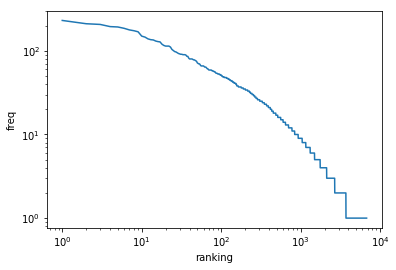

In [0]:
freq = [v for (k,v) in sorted_d] # Lista de frequencias
ranking_list = [x+1 for x in range(len(freq))]

# Retorna vocabulario com tokens "stemizados". O vocabulario seria um dicionario com chave=token_stemizado e valor o numero de ocorrencias
def return_new_stemmed_vocabulary():
  stemmed_vocab = {}
  for key, value in sorted_d:
    if(stemmer.stem(key) not in stemmed_vocab):
      stemmed_vocab[stemmer.stem(key)] = value
    else:
      stemmed_vocab[stemmer.stem(key)] = stemmed_vocab[stemmer.stem(key)] + value
  return stemmed_vocab
  
stemmed_vocabulary = return_new_stemmed_vocabulary()
sorted_vocab = sorted(stemmed_vocabulary.items(), key=operator.itemgetter(1), reverse = True)
stemmed_freq = [v for (k,v) in sorted_vocab]
stemmed_ranking = [x+1 for x in range(len(stemmed_freq))]

pyplot.plot(stemmed_ranking, stemmed_freq)
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlabel('ranking')
pyplot.ylabel('freq')